In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## **Data Preprocessing**

### LOADING THE DATASET

Reference of the dataset : https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf  
Dataset and methodology followed is decribed in greater detail in the above cited link.


In [12]:
# we will load the cifar10 dataset from keras
# reference : https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
# dataset and methodology followed is decribed in greater detail in the above cited link.
from keras.datasets import cifar10

(X_train, y_train),(X_test, y_test) = cifar10.load_data()


ABOUT THE DATASET -


*   The dataset has 50000 training samples and 10000 test samples
*   cifar10 implies 10 class labels (or target labels)
*   Each sample has the shape (32,32,3)
*   Pixels in 32X32 images are indexed in values of three channels of Red, Blue and Green



In [13]:
print(f'Shape of the training set (features): {X_train.shape}')
print(f'Shape of the training set (target): {y_train.shape}')
print(f'Shape of the test set (features): {X_test.shape}')
print(f'Shape of the test set (target): {y_test.shape}')


Shape of the training set (features): (50000, 32, 32, 3)
Shape of the training set (target): (50000, 1)
Shape of the test set (features): (10000, 32, 32, 3)
Shape of the test set (target): (10000, 1)


### Visualizing the image set

Text(0.5, 1.0, 'A single image')

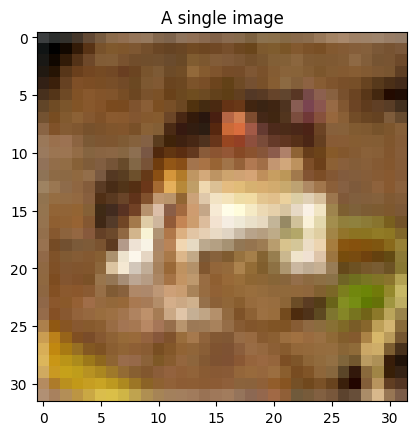

In [14]:
#plotting the first sample of the trainging set
plt.imshow(X_train[0])
plt.title('A single image')

In [15]:
print(y_train)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


The target set contains integer class labels representing one of the ten classes in the CIFAR-10 dataset.

In [16]:
# These are the classnames in the dataset in the order
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


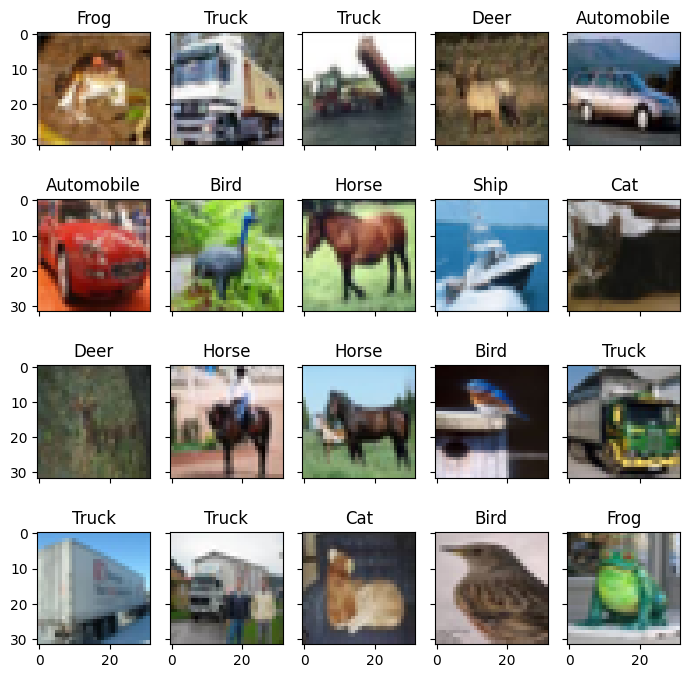

In [17]:
# Making a subplot of first few images

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(7,7), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
  ax.imshow(X_train[i])
  ax.set_title(class_names[y_train[i][0]])


plt.tight_layout()
plt.show()

In [18]:
# Flattening the features array

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# As the pixel values in rgb channel of feature set range from 0-255 we are scaling it down to 0.0-1.0

min_value = np.min(X_train)
max_value = np.max(X_train)
# Perform min-max normalization
X_train_normalized = (X_train - min_value) / (max_value - min_value)
X_test_normalized = (X_test - min_value) / (max_value - min_value)

In [19]:
# Flatten target labels
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [20]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
# Train the classifier
knn_classifier.fit(X_train, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3398
